In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
df_flights = pd.read_csv('../FlightData/flights_SFO_UA.csv')
df_planes = pd.read_csv('../PlaneData/MainlineFleet.csv')
df_holiday = pd.read_csv('../HolidayData/holidays_2023_2024.csv')
df_future_flights = pd.read_csv('../FutureData/future_flights_data.csv')
df_weather = pd.read_csv('../WeatherData/hourly_dataframe_past (1).csv')
df_future_weather = pd.read_csv('../WeatherData/hourly_dataframe_forecast (1).csv')

In [3]:
df_planes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1834 entries, 0 to 1833
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PLANE_MODEL  1819 non-null   object
 1   TAIL_NUM     1584 non-null   object
dtypes: object(2)
memory usage: 28.8+ KB


In [ ]:
df_express_fleet = pd.read_csv('../PlaneData/ExpressFleet.csv')
df_mainline_fleet = pd.read_csv('../PlaneData/MainlineFleet.csv')

df_planes = pd.concat([df_express_fleet, df_mainline_fleet], ignore_index=True)

df_flights_plane = df_flights.merge(df_planes[['PLANE_MODEL', 'TAIL_NUM']], how='left', left_on='TAIL_NUM', right_on='TAIL_NUM')

In [6]:
for origin, dest in df_flights_plane[['ORIGIN_CITY_NAME', 'DEST_CITY_NAME']].drop_duplicates().values:
    mask = (df_flights_plane['ORIGIN_CITY_NAME'] == origin) & (df_flights_plane['DEST_CITY_NAME'] == dest)
    
    plane_model = df_flights_plane.loc[mask, 'PLANE_MODEL'].dropna().unique()
    
    if len(plane_model) > 0:
        df_flights_plane.loc[mask & df_flights_plane['PLANE_MODEL'].isna(), 'PLANE_MODEL'] = plane_model[0]


In [7]:
unique_tail_nums = df_flights_plane['TAIL_NUM'].nunique()
unique_tail_nums_no_model = df_flights_plane[df_flights_plane['PLANE_MODEL'].isna()]['TAIL_NUM'].nunique()
percentage_unique_no_model = (unique_tail_nums_no_model / unique_tail_nums) * 100

total_rows = len(df_flights_plane)
rows_no_model = df_flights_plane['PLANE_MODEL'].isna().sum()
percentage_rows_no_model = (rows_no_model / total_rows) * 100

print(f"Percentage of unique TAIL_NUM that have no model: {percentage_unique_no_model:.2f}%")
print(f"Percentage of all rows that have no model: {percentage_rows_no_model:.2f}%")


Percentage of unique TAIL_NUM that have no model: 0.11%
Percentage of all rows that have no model: 0.00%


In [9]:
df_flights_plane = df_flights_plane.dropna(subset=['PLANE_MODEL'])

In [10]:
flights_plane_csv_path = '/Users/judith.rethmann/Documents/MBS/PredictiveAnalytics/Model/flights_plane.csv'
df_flights_plane.to_csv(flights_plane_csv_path, index=False)
print(f"Combined CSV file saved as '{flights_plane_csv_path}'")


Combined CSV file saved as '/Users/judith.rethmann/Documents/MBS/PredictiveAnalytics/Model/flights_plane.csv'


In [15]:
df_flights_plane['DEST_CITY_NAME'] = df_flights_plane['DEST_CITY_NAME'].str.replace(r',.*', '', regex=True)
df_flights_plane['ORIGIN_CITY_NAME'] = df_flights_plane['ORIGIN_CITY_NAME'].str.replace(r',.*', '', regex=True)

/var/folders/hx/g2lg_kq17xgb1zndw9jlbyn80000gn/T/ipykernel_46091/506844661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flights_plane['DEST_CITY_NAME'] = df_flights_plane['DEST_CITY_NAME'].str.replace(r',.*', '', regex=True)
/var/folders/hx/g2lg_kq17xgb1zndw9jlbyn80000gn/T/ipykernel_46091/506844661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flights_plane['ORIGIN_CITY_NAME'] = df_flights_plane['ORIGIN_CITY_NAME'].str.replace(r',.*', '', regex=True)


In [16]:
df_future_flights = df_future_flights.drop(columns=[
    'flightnumber', 
    'airport_name', 
    'airport_IATA', 
    'aircraft_name', 
    'arrival_time', 
    'codeshare_info',
    'carrier'
])

df_future_flights = df_future_flights.rename(columns={
    'clean_date': 'FL_DATE',
    'airport_city_name': 'DEST_CITY_NAME',
    'aircraft_IATA': 'PLANE_MODEL',
    'departure_time': 'DEP_TIME',
    'elapsed_time': 'AIR_TIME'
})

In [17]:
columns_to_drop = [
    'ORIGIN_AIRPORT_ID', 
    'OP_UNIQUE_CARRIER', 
    'OP_CARRIER_FL_NUM', 
    'TAIL_NUM', 
    'YEAR', 
    'MONTH', 
    'DAY_OF_MONTH', 
    'DEST_AIRPORT_ID', 
    'DEP_DELAY',
    'ORIGIN_CITY_NAME'
]

df_flights_plane = df_flights_plane.drop(columns=columns_to_drop)

In [18]:
df_future_flights['FL_DATE'] = pd.to_datetime(df_future_flights['FL_DATE'])
df_future_flights['DAY_OF_WEEK'] = df_future_flights['FL_DATE'].dt.dayofweek
df_flights_plane['FL_DATE'] = pd.to_datetime(df_flights_plane['FL_DATE'])
df_flights_plane['DAY_OF_WEEK'] = df_flights_plane['FL_DATE'].dt.dayofweek

In [ ]:
columns_order_future = ['FL_DATE', 'DAY_OF_WEEK', 'DEST_CITY_NAME', 'AIR_TIME', 'DEP_TIME', 'PLANE_MODEL']
df_future_flights = df_future_flights[columns_order_future]
columns_order_past = ['FL_DATE', 'DAY_OF_WEEK', 'DEST_CITY_NAME', 'AIR_TIME', 'DEP_TIME', 'PLANE_MODEL', 'DEP_DEL15']
df_flights_plane = df_flights_plane[columns_order_past]

df_future_flights['AIR_TIME'] = df_future_flights['AIR_TIME'].astype('float64')
df_flights_plane['DEP_DEL15'] = df_flights_plane['DEP_DEL15'].astype('int')

In [ ]:
cols_to_convert = ['relative_humidity_2m', 'precipitation', 'wind_speed_10m']

for col in cols_to_convert:
    df_weather[col] = df_weather[col].astype(float).round().astype(int)

In [26]:
def split_date_time(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col])
    df['time'] = df[date_col].dt.time
    df[date_col] = df[date_col].dt.date
    return df

df_weather = split_date_time(df_weather, 'date')
df_future_weather = split_date_time(df_future_weather, 'date')

In [ ]:
def extract_hour(df, time_col):
    df[time_col] = df[time_col].astype(str)
    df['hour'] = df[time_col].str.extract(r'(\d{2})').astype(int)
    return df

df_flights_plane['DEP_TIME'] = df_flights_plane['DEP_TIME'].astype(str)
df_future_flights['DEP_TIME'] = df_future_flights['DEP_TIME'].astype(str)
df_weather['time'] = df_weather['time'].astype(str)
df_future_weather['time'] = df_future_weather['time'].astype(str)

df_flights_plane = extract_hour(df_flights_plane, 'DEP_TIME')
df_future_flights = extract_hour(df_future_flights, 'DEP_TIME')
df_weather = extract_hour(df_weather, 'time')
df_future_weather = extract_hour(df_future_weather, 'time')

df_flights_plane['FL_DATE'] = pd.to_datetime(df_flights_plane['FL_DATE'])
df_future_flights['FL_DATE'] = pd.to_datetime(df_future_flights['FL_DATE'])
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_future_weather['date'] = pd.to_datetime(df_future_weather['date'])

df_merged_weather = pd.merge(df_flights_plane, df_weather, left_on=['FL_DATE', 'hour'], right_on=['date', 'hour'], how='left')
df_merged_future_weather = pd.merge(df_future_flights, df_future_weather, left_on=['FL_DATE', 'hour'], right_on=['date', 'hour'], how='left')

df_merged_weather = df_merged_weather.drop(columns=['hour', 'date', 'time'])
df_merged_future_weather = df_merged_future_weather.drop(columns=['hour', 'date', 'time'])

In [ ]:
df_holiday['ds'] = pd.to_datetime(df_holiday['ds'])

df_merged_weather = pd.merge(df_merged_weather, df_holiday[['ds', 'holiday_status']], left_on='FL_DATE', right_on='ds', how='left')
df_merged_future_weather = pd.merge(df_merged_future_weather, df_holiday[['ds', 'holiday_status']], left_on='FL_DATE', right_on='ds', how='left')

df_merged_weather['IS_HOLIDAY'] = df_merged_weather['holiday_status'].apply(lambda x: 1 if x else 0)
df_merged_future_weather['IS_HOLIDAY'] = df_merged_future_weather['holiday_status'].apply(lambda x: 1 if x else 0)

df_past_data = df_merged_weather.drop(columns=['ds', 'holiday_status'])
df_future_data = df_merged_future_weather.drop(columns=['ds', 'holiday_status'])

In [32]:
past_data_path = '/Users/judith.rethmann/Documents/MBS/PredictiveAnalytics/Model/past_data.csv'
df_past_data.to_csv(past_data_path, index=False)
print(f"past data file saved as '{past_data_path}'")

future_data_path = '/Users/judith.rethmann/Documents/MBS/PredictiveAnalytics/Model/future_data.csv'
df_future_data.to_csv(future_data_path, index=False)
print(f"future data file saved as '{future_data_path}'")

past data file saved as '/Users/judith.rethmann/Documents/MBS/PredictiveAnalytics/Model/past_data.csv'
future data file saved as '/Users/judith.rethmann/Documents/MBS/PredictiveAnalytics/Model/future_data.csv'


# BUILD MODEL

In [ ]:
'''df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_prophet = df_past_data.rename(columns={'FL_DATE': 'ds', 'DEP_DEL15': 'y'})

df_prophet = df_prophet[['ds', 'y']]

train_size = int(len(df_prophet) * 0.7)
train_df = df_prophet[:train_size]
test_df = df_prophet[train_size:]
'''

In [ ]:
'''model = Prophet()

model.fit(train_df)'''

In [ ]:
'''forecast_test = model.predict(test_df[['ds']])

threshold = 0.5 
forecast_test['yhat_binary'] = (forecast_test['yhat'] >= threshold).astype(int)

forecast_test = forecast_test[['ds', 'yhat', 'yhat_binary']].merge(test_df, on='ds', how='left')
'''

In [ ]:
'''print("Classification Report:")
print(classification_report(forecast_test['y'], forecast_test['yhat_binary']))

print("Confusion Matrix:")
print(confusion_matrix(forecast_test['y'], forecast_test['yhat_binary']))

print("Accuracy Score:")
print(accuracy_score(forecast_test['y'], forecast_test['yhat_binary']))
'''

### Prophet seems to struggle with binary classification, it is just predicting the majority class. I will try random forest

In [ ]:
'''df_past_data['year'] = df_past_data['FL_DATE'].dt.year
df_past_data['month'] = df_past_data['FL_DATE'].dt.month
df_past_data['day'] = df_past_data['FL_DATE'].dt.day
df_past_data['dayofweek'] = df_past_data['FL_DATE'].dt.dayofweek

features = ['year', 'month', 'day', 'dayofweek', 'temperature_2m', 'relative_humidity_2m', 
            'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))
'''

In [ ]:
'''df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_past_data['year'] = df_past_data['FL_DATE'].dt.year
df_past_data['month'] = df_past_data['FL_DATE'].dt.month
df_past_data['day'] = df_past_data['FL_DATE'].dt.day
df_past_data['dayofweek'] = df_past_data['FL_DATE'].dt.dayofweek

features = ['year', 'month', 'day', 'dayofweek', 'temperature_2m', 'relative_humidity_2m', 
            'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred_rf))

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("XGBoost Accuracy Score:")
print(accuracy_score(y_test, y_pred_xgb))

gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train, y_train)
y_pred_gbc = gbc_model.predict(X_test)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gbc))
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gbc))
print("Gradient Boosting Accuracy Score:")
print(accuracy_score(y_test, y_pred_gbc))
'''

In [ ]:
'''df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_past_data['year'] = df_past_data['FL_DATE'].dt.year
df_past_data['month'] = df_past_data['FL_DATE'].dt.month
df_past_data['day'] = df_past_data['FL_DATE'].dt.day
df_past_data['dayofweek'] = df_past_data['FL_DATE'].dt.dayofweek

features = ['year', 'month', 'day', 'dayofweek', 'temperature_2m', 'relative_humidity_2m', 
            'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_params = grid_search.best_params_
best_xgb_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb_model.fit(X_train, y_train)

y_pred_best_xgb = best_xgb_model.predict(X_test)

print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb))

print("Best XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_xgb))

print("Best XGBoost Accuracy Score:")
print(accuracy_score(y_test, y_pred_best_xgb))
'''

### although xg boost performed best, it is not performing well on actually delayed flights. Random Forest was better for this. I will first try weighting false negatives higher and otherwise go with random forest

In [ ]:
'''df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_past_data['year'] = df_past_data['FL_DATE'].dt.year
df_past_data['month'] = df_past_data['FL_DATE'].dt.month
df_past_data['day'] = df_past_data['FL_DATE'].dt.day
df_past_data['dayofweek'] = df_past_data['FL_DATE'].dt.dayofweek

features = ['year', 'month', 'day', 'dayofweek', 'temperature_2m', 'relative_humidity_2m', 
            'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_model = xgb.XGBClassifier(scale_pos_weight=class_weight_dict[1] / class_weight_dict[0], 
                              use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_params = grid_search.best_params_
best_xgb_model = xgb.XGBClassifier(**best_params, scale_pos_weight=class_weight_dict[1] / class_weight_dict[0], 
                                   use_label_encoder=False, eval_metric='logloss', random_state=42)
best_xgb_model.fit(X_train, y_train)

y_pred_best_xgb = best_xgb_model.predict(X_test)

print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb))

print("Best XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_xgb))

print("Best XGBoost Accuracy Score:")
print(accuracy_score(y_test, y_pred_best_xgb))
'''

### This lowererd the performance. I will go with random forest instead

In [ ]:
'''df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_past_data['year'] = df_past_data['FL_DATE'].dt.year
df_past_data['month'] = df_past_data['FL_DATE'].dt.month
df_past_data['day'] = df_past_data['FL_DATE'].dt.day
df_past_data['dayofweek'] = df_past_data['FL_DATE'].dt.dayofweek

features = ['year', 'month', 'day', 'dayofweek', 'temperature_2m', 'relative_humidity_2m', 
            'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_params = grid_search.best_params_
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

y_pred_best_rf = best_rf_model.predict(X_test)

print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))

print("Best Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))

print("Best Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred_best_rf))
'''

### not bad. I will try optimizing with the f1 score to find a better balance the true and false positives

In [ ]:
'''features = ['year', 'month', 'day', 'dayofweek', 'temperature_2m', 'relative_humidity_2m', 
            'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='f1', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

best_params = grid_search.best_params_
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

y_pred_best_rf = best_rf_model.predict(X_test)

print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))

print("Best Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))

print("Best Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred_best_rf))'''

### this has a slightly lower accuracy, but performs better on the actually delayed flights. I will try some other features and maybe oversample

In [ ]:
'''df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_past_data['DEP_TIME'] = pd.to_datetime(df_past_data['DEP_TIME'], format='%H:%M:%S', errors='coerce')
df_past_data['DEP_HOUR'] = df_past_data['DEP_TIME'].dt.hour
df_past_data['DEP_MINUTE'] = df_past_data['DEP_TIME'].dt.minute

features = ['DEST_CITY_NAME', 'AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'PLANE_MODEL', 
            'temperature_2m', 'relative_humidity_2m', 'precipitation', 'pressure_msl', 
            'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_features = ['DEST_CITY_NAME', 'PLANE_MODEL']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numeric_features = ['AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'temperature_2m', 'relative_humidity_2m', 
                    'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 
                    'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           scoring='f1', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

best_params = grid_search.best_params_
best_rf_model = RandomForestClassifier(
    n_estimators=best_params['classifier__n_estimators'],
    max_depth=best_params['classifier__max_depth'],
    min_samples_split=best_params['classifier__min_samples_split'],
    min_samples_leaf=best_params['classifier__min_samples_leaf'],
    bootstrap=best_params['classifier__bootstrap'],
    random_state=42
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

X_train_res = preprocessor.fit_transform(X_train_res)

best_rf_model.fit(X_train_res, y_train_res)

X_test_preprocessed = preprocessor.transform(X_test)

y_pred_best_rf = best_rf_model.predict(X_test_preprocessed)

print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))

print("Best Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))

print("Best Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred_best_rf))

feature_importances = best_rf_model.feature_importances_

feature_names = numeric_features + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))

feature_importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print("Feature Importances:")
print(feature_importances_df)
'''

### It seems like I applied smote before the processing which cause issues. to cut down the run time I will use the best parameters when I fix the issue

In [49]:
df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_past_data['year'] = df_past_data['FL_DATE'].dt.year
df_past_data['month'] = df_past_data['FL_DATE'].dt.month
df_past_data['day'] = df_past_data['FL_DATE'].dt.day
df_past_data['dayofweek'] = df_past_data['FL_DATE'].dt.dayofweek

'''df_past_data['FL_DATE'] = pd.to_datetime(df_past_data['FL_DATE'])

df_past_data['DEP_TIME'] = pd.to_datetime(df_past_data['DEP_TIME'], format='%H:%M:%S', errors='coerce')
df_past_data['DEP_HOUR'] = df_past_data['DEP_TIME'].dt.hour
df_past_data['DEP_MINUTE'] = df_past_data['DEP_TIME'].dt.minute'''

features = ['DEST_CITY_NAME', 'AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'PLANE_MODEL', 
            'temperature_2m', 'relative_humidity_2m', 'precipitation', 'pressure_msl', 
            'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_features = ['DEST_CITY_NAME', 'PLANE_MODEL']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numeric_features = ['AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'temperature_2m', 'relative_humidity_2m', 
                    'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 
                    'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=False,
    random_state=42
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE to the preprocessed training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Train the model on the resampled and preprocessed training data
best_rf_model.fit(X_train_res, y_train_res)

y_pred_best_rf = best_rf_model.predict(X_test_preprocessed)

print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))

print("Best Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))

print("Best Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred_best_rf))

feature_importances = best_rf_model.feature_importances_

feature_names = numeric_features + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))

feature_importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print("Feature Importances:")
display(feature_importances_df)


Best Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     11849
           1       0.80      0.35      0.48      3223

    accuracy                           0.84     15072
   macro avg       0.82      0.66      0.69     15072
weighted avg       0.84      0.84      0.82     15072

Best Random Forest Confusion Matrix:
[[11569   280]
 [ 2110  1113]]
Best Random Forest Accuracy Score:
0.8414278131634819
Feature Importances:


,feature,importance
1,DEP_HOUR,0.125493
2,DEP_MINUTE,0.074349
11,month,0.066651
72,PLANE_MODEL_39M,0.062609
0,AIR_TIME,0.058889
...,...,...
23,DEST_CITY_NAME_Burbank,0.000089
32,DEST_CITY_NAME_Fresno,0.000063
45,DEST_CITY_NAME_Madison,0.000044
38,DEST_CITY_NAME_Kalispell,0.000036


In [52]:
feature_importances_df.to_csv('feature_importances.csv', index=False)

In [57]:
features = ['AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'PLANE_MODEL', 
            'temperature_2m', 'relative_humidity_2m', 'precipitation', 'pressure_msl', 
            'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

X = df_past_data[features]
y = df_past_data['DEP_DEL15']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_features = ['PLANE_MODEL']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numeric_features = ['AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'temperature_2m', 'relative_humidity_2m', 
                    'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 
                    'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Train the Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=False,
    random_state=42
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE to the preprocessed training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Train the model on the resampled and preprocessed training data
best_rf_model.fit(X_train_res, y_train_res)

y_pred_best_rf = best_rf_model.predict(X_test_preprocessed)

print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf))

print("Best Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))

print("Best Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred_best_rf))

feature_importances = best_rf_model.feature_importances_

feature_names = numeric_features + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))

feature_importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print("Feature Importances:")
display(feature_importances_df)


Best Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     11849
           1       0.69      0.40      0.50      3223

    accuracy                           0.83     15072
   macro avg       0.77      0.67      0.70     15072
weighted avg       0.82      0.83      0.81     15072

Best Random Forest Confusion Matrix:
[[11269   580]
 [ 1942  1281]]
Best Random Forest Accuracy Score:
0.8326698513800425
Feature Importances:


,feature,importance
1,DEP_HOUR,0.157227
2,DEP_MINUTE,0.092343
0,AIR_TIME,0.085123
16,PLANE_MODEL_39M,0.076003
11,month,0.074809
3,temperature_2m,0.049333
4,relative_humidity_2m,0.048101
15,PLANE_MODEL_38M,0.044916
7,cloud_cover,0.043779
6,pressure_msl,0.041905


In [59]:
feature_importances_df.to_csv('feature_importances_without_destinations.csv', index=False)

### The Destinations seem to be not very important. Also, they may cause an issue later if there are new destinations. Therefore, I will remove them

### Next, I will use the model to predict delays on the future data

In [77]:
df_future_data_processed = df_future_data.copy()

df_future_data_processed['FL_DATE'] = pd.to_datetime(df_future_data_processed['FL_DATE'])

df_future_data_processed['year'] = df_future_data_processed['FL_DATE'].dt.year
df_future_data_processed['month'] = df_future_data_processed['FL_DATE'].dt.month
df_future_data_processed['day'] = df_future_data_processed['FL_DATE'].dt.day
df_future_data_processed['dayofweek'] = df_future_data_processed['FL_DATE'].dt.dayofweek

df_future_data_processed['DEP_TIME'] = pd.to_datetime(df_future_data_processed['DEP_TIME'], format='%H:%M', errors='coerce')
df_future_data_processed['DEP_HOUR'] = df_future_data_processed['DEP_TIME'].dt.hour
df_future_data_processed['DEP_MINUTE'] = df_future_data_processed['DEP_TIME'].dt.minute


features = ['AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'PLANE_MODEL', 
            'temperature_2m', 'relative_humidity_2m', 'precipitation', 'pressure_msl', 
            'cloud_cover', 'wind_speed_10m', 'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

X_future = df_future_data_processed[features]

categorical_features = ['PLANE_MODEL']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

encoder_plane_model = OneHotEncoder(handle_unknown='ignore')
encoder_plane_model.fit(df_past_data[['PLANE_MODEL']])

plane_model_encoded = encoder_plane_model.transform(df_future_data_processed[['PLANE_MODEL']]).toarray()
plane_model_encoded_df = pd.DataFrame(plane_model_encoded, columns=encoder_plane_model.get_feature_names_out(['PLANE_MODEL']))

df_future_data_processed.reset_index(drop=True, inplace=True)

df_future_data_processed = pd.concat([df_future_data_processed, plane_model_encoded_df], axis=1)

df_future_data_processed.drop(columns=['PLANE_MODEL'], inplace=True)

numeric_features = ['AIR_TIME', 'DEP_HOUR', 'DEP_MINUTE', 'temperature_2m', 'relative_humidity_2m', 
                    'precipitation', 'pressure_msl', 'cloud_cover', 'wind_speed_10m', 
                    'IS_HOLIDAY', 'year', 'month', 'day', 'dayofweek']

features_final = numeric_features + list(plane_model_encoded_df.columns)

X_future_preprocessed = df_future_data_processed[features_final]

y_pred_future = best_rf_model.predict(X_future_preprocessed)
y_pred_proba_future = best_rf_model.predict_proba(X_future_preprocessed)[:, 1]

df_future_data_processed['PRED_DEL15'] = y_pred_future
df_future_data_processed['CONF'] = y_pred_proba_future

percentage_delayed = (df_future_data_processed['PRED_DEL15'].sum() / len(df_future_data_processed)) * 100

print("Updated df_future_data_processed:")
print(df_future_data_processed)

print(f"Percentage of flights predicted to be delayed: {percentage_delayed:.2f}%")


Updated df_future_data_processed:
       FL_DATE  DAY_OF_WEEK DEST_CITY_NAME  AIR_TIME            DEP_TIME  \
0   2024-05-31            4        Houston     236.0 1900-01-01 00:30:00   
1   2024-05-31            4         Manila     850.0 1900-01-01 00:45:00   
2   2024-05-31            4        Chicago     260.0 1900-01-01 01:10:00   
3   2024-05-31            4        Houston     243.0 1900-01-01 05:00:00   
4   2024-05-31            4         Denver     157.0 1900-01-01 05:00:00   
..         ...          ...            ...       ...                 ...   
198 2024-05-31            4         Taipei     800.0 1900-01-01 23:45:00   
199 2024-05-31            4      Hong Kong     850.0 1900-01-01 23:50:00   
200 2024-05-31            4          Seoul     745.0 1900-01-01 23:55:00   
201 2024-05-31            4        Houston     235.0 1900-01-01 23:59:00   
202 2024-05-31            4   Philadelphia     334.0 1900-01-01 23:59:00   

     temperature_2m  relative_humidity_2m  precipitat

/Users/judith.rethmann/Library/Caches/pypoetry/virtualenvs/pythonproject-_Wdx5WR7-py3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/judith.rethmann/Library/Caches/pypoetry/virtualenvs/pythonproject-_Wdx5WR7-py3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [79]:
df_future_data_processed.to_csv('prediction_2024_05_31.csv', index=False)

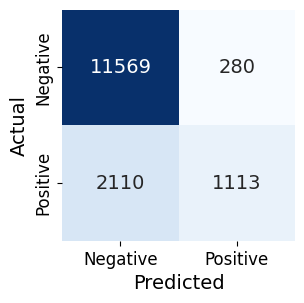

In [85]:
conf_matrix = np.array([[11569, 280],
                        [2110, 1113]])

conf_matrix_df = pd.DataFrame(conf_matrix, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])

plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
